In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json

In [14]:
patient_path = "/data/wang/junh/githubs/Debate/KARE/data/ehr_data/mimic3_mortality_samples_test.json"
base_path_rag = "/data/wang/junh/githubs/Debate/KARE/results/rag"

- Which patient always been predicted wrong?

Total patients: 996
Always-wrong patients: 1
Patients with retries: 141


/tmp/ipykernel_1871161/51840723.py:115: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(box_data, labels=labels, patch_artist=True)


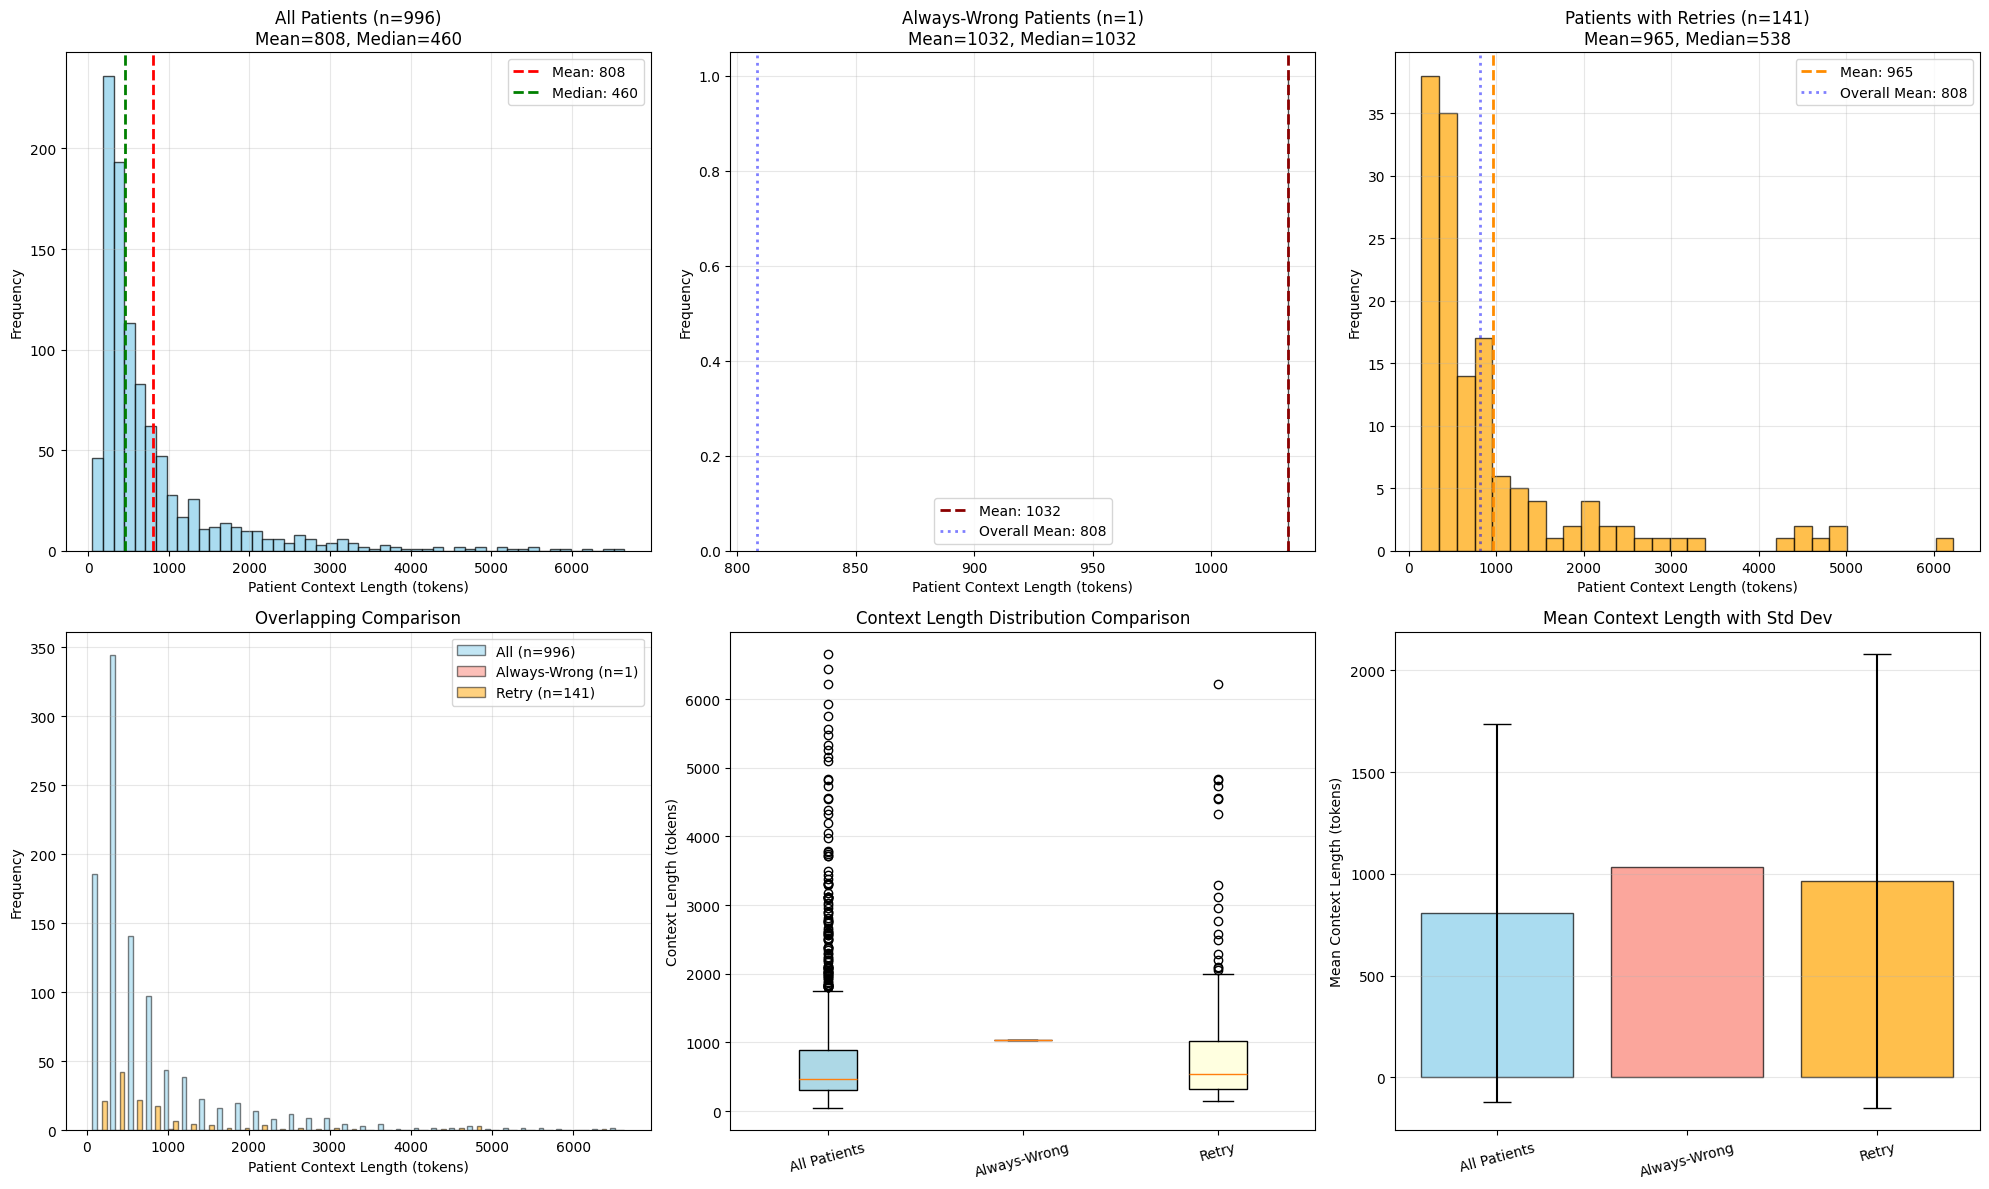


PATIENT CONTEXT LENGTH STATISTICS - GROUP COMPARISON

All Patients (n=996):
  Mean: 808.36 tokens
  Median: 459.75 tokens
  Std: 929.53 tokens
  Min: 48, Max: 6653

Always-Wrong Patients (n=1):
  Mean: 1032.25 tokens
  Median: 1032.25 tokens
  Std: nan tokens
  Min: 1032, Max: 1032
  Difference from overall mean: +223.89 tokens (+27.70%)

Patients with Retries (n=141):
  Mean: 964.93 tokens
  Median: 538.00 tokens
  Std: 1113.51 tokens
  Min: 142, Max: 6223
  Difference from overall mean: +156.57 tokens (+19.37%)

Statistical Test: All vs Always-Wrong
  t-statistic: -0.2407
  p-value: 0.8098
  → No significant difference (p >= 0.05)

Statistical Test: All vs Retry
  t-statistic: -1.8237
  p-value: 0.0685
  → No significant difference (p >= 0.05)

Statistical Test: Always-Wrong vs Retry
  t-statistic: 0.0602
  p-value: 0.9520
  → No significant difference (p >= 0.05)

GROUP OVERLAP ANALYSIS
Patients both always-wrong AND with retries: 1
  Mean context length: 1032.25 tokens


In [20]:
# from the dataset in patient_path, plot the distribution of the patient context lengths
# Compare: All 996 patients vs Always-wrong patients vs Retry patients

# Calculate patient context lengths
patient_context_lengths = []

for patient in patient_data:
    # Concatenate all patient data fields to estimate context length
    context_parts = []
    
    # Add conditions
    if 'conditions' in patient and patient['conditions']:
        for visit_conditions in patient['conditions']:
            context_parts.extend(visit_conditions)
    
    # Add procedures
    if 'procedures' in patient and patient['procedures']:
        for visit_procedures in patient['procedures']:
            context_parts.extend(visit_procedures)
    
    # Add drugs
    if 'drugs' in patient and patient['drugs']:
        for visit_drugs in patient['drugs']:
            context_parts.extend(visit_drugs)
    
    # Calculate total length in tokens (approx 4 chars per token)
    total_context = ' '.join(context_parts)
    context_length = len(total_context) / 4  # Convert to tokens
    
    patient_context_lengths.append({
        'patient_id': f"{patient['patient_id']}_{patient['visit_id']}",
        'context_length': context_length,
        'num_conditions': len(patient['conditions'][0]) if patient.get('conditions') else 0,
        'num_procedures': len(patient['procedures'][0]) if patient.get('procedures') else 0,
        'num_drugs': len(patient['drugs'][0]) if patient.get('drugs') else 0,
        'label': patient['label']
    })

context_df = pd.DataFrame(patient_context_lengths)

# Get always-wrong patients from first analysis
always_wrong_ids = always_wrong if 'always_wrong' in locals() else []

# Get retry patients from second analysis
retry_patient_ids = list(all_retry_patients.keys()) if 'all_retry_patients' in locals() else []

print(f"Total patients: {len(context_df)}")
print(f"Always-wrong patients: {len(always_wrong_ids)}")
print(f"Patients with retries: {len(retry_patient_ids)}")

# Filter data for each group
all_lengths = context_df['context_length']
always_wrong_lengths = context_df[context_df['patient_id'].isin(always_wrong_ids)]['context_length']
retry_lengths = context_df[context_df['patient_id'].isin(retry_patient_ids)]['context_length']

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: Overall distribution
axes[0, 0].hist(all_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Patient Context Length (tokens)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(f'All Patients (n={len(all_lengths)})\nMean={all_lengths.mean():.0f}, Median={all_lengths.median():.0f}')
axes[0, 0].axvline(all_lengths.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_lengths.mean():.0f}')
axes[0, 0].axvline(all_lengths.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {all_lengths.median():.0f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Always-wrong distribution
if len(always_wrong_lengths) > 0:
    axes[0, 1].hist(always_wrong_lengths, bins=30, alpha=0.7, color='salmon', edgecolor='black')
    axes[0, 1].set_xlabel('Patient Context Length (tokens)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title(f'Always-Wrong Patients (n={len(always_wrong_lengths)})\nMean={always_wrong_lengths.mean():.0f}, Median={always_wrong_lengths.median():.0f}')
    axes[0, 1].axvline(always_wrong_lengths.mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {always_wrong_lengths.mean():.0f}')
    axes[0, 1].axvline(all_lengths.mean(), color='blue', linestyle=':', linewidth=2, alpha=0.5, label=f'Overall Mean: {all_lengths.mean():.0f}')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'No always-wrong patients', ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Always-Wrong Patients')

# Plot 3: Retry distribution
if len(retry_lengths) > 0:
    axes[0, 2].hist(retry_lengths, bins=30, alpha=0.7, color='orange', edgecolor='black')
    axes[0, 2].set_xlabel('Patient Context Length (tokens)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title(f'Patients with Retries (n={len(retry_lengths)})\nMean={retry_lengths.mean():.0f}, Median={retry_lengths.median():.0f}')
    axes[0, 2].axvline(retry_lengths.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'Mean: {retry_lengths.mean():.0f}')
    axes[0, 2].axvline(all_lengths.mean(), color='blue', linestyle=':', linewidth=2, alpha=0.5, label=f'Overall Mean: {all_lengths.mean():.0f}')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
else:
    axes[0, 2].text(0.5, 0.5, 'No retry patients', ha='center', va='center', transform=axes[0, 2].transAxes)
    axes[0, 2].set_title('Patients with Retries')

# Plot 4: Overlapping histograms for comparison
axes[1, 0].hist([all_lengths, always_wrong_lengths, retry_lengths], bins=30, alpha=0.5, 
                color=['skyblue', 'salmon', 'orange'], 
                label=[f'All (n={len(all_lengths)})', 
                       f'Always-Wrong (n={len(always_wrong_lengths)})', 
                       f'Retry (n={len(retry_lengths)})'], 
                edgecolor='black')
axes[1, 0].set_xlabel('Patient Context Length (tokens)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Overlapping Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Box plot comparison
box_data = [all_lengths, always_wrong_lengths, retry_lengths] if len(always_wrong_lengths) > 0 and len(retry_lengths) > 0 else []
labels = ['All Patients', 'Always-Wrong', 'Retry']

if len(box_data) > 0:
    bp = axes[1, 1].boxplot(box_data, labels=labels, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    if len(bp['boxes']) > 1:
        bp['boxes'][1].set_facecolor('lightcoral')
    if len(bp['boxes']) > 2:
        bp['boxes'][2].set_facecolor('lightyellow')
    axes[1, 1].set_ylabel('Context Length (tokens)')
    axes[1, 1].set_title('Context Length Distribution Comparison')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].tick_params(axis='x', rotation=15)
else:
    axes[1, 1].text(0.5, 0.5, 'Insufficient data', ha='center', va='center', transform=axes[1, 1].transAxes)

# Plot 6: Statistical summary bars
if len(always_wrong_lengths) > 0 and len(retry_lengths) > 0:
    means = [all_lengths.mean(), always_wrong_lengths.mean(), retry_lengths.mean()]
    stds = [all_lengths.std(), always_wrong_lengths.std(), retry_lengths.std()]
    
    x_pos = np.arange(len(labels))
    axes[1, 2].bar(x_pos, means, yerr=stds, alpha=0.7, color=['skyblue', 'salmon', 'orange'], 
                   edgecolor='black', capsize=10)
    axes[1, 2].set_ylabel('Mean Context Length (tokens)')
    axes[1, 2].set_title('Mean Context Length with Std Dev')
    axes[1, 2].set_xticks(x_pos)
    axes[1, 2].set_xticklabels(labels, rotation=15)
    axes[1, 2].grid(True, alpha=0.3, axis='y')
else:
    axes[1, 2].text(0.5, 0.5, 'Insufficient data', ha='center', va='center', transform=axes[1, 2].transAxes)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "=" * 80)
print("PATIENT CONTEXT LENGTH STATISTICS - GROUP COMPARISON")
print("=" * 80)

print(f"\nAll Patients (n={len(all_lengths)}):")
print(f"  Mean: {all_lengths.mean():.2f} tokens")
print(f"  Median: {all_lengths.median():.2f} tokens")
print(f"  Std: {all_lengths.std():.2f} tokens")
print(f"  Min: {all_lengths.min():.0f}, Max: {all_lengths.max():.0f}")

if len(always_wrong_lengths) > 0:
    print(f"\nAlways-Wrong Patients (n={len(always_wrong_lengths)}):")
    print(f"  Mean: {always_wrong_lengths.mean():.2f} tokens")
    print(f"  Median: {always_wrong_lengths.median():.2f} tokens")
    print(f"  Std: {always_wrong_lengths.std():.2f} tokens")
    print(f"  Min: {always_wrong_lengths.min():.0f}, Max: {always_wrong_lengths.max():.0f}")
    print(f"  Difference from overall mean: {always_wrong_lengths.mean() - all_lengths.mean():+.2f} tokens ({(always_wrong_lengths.mean() - all_lengths.mean())/all_lengths.mean()*100:+.2f}%)")

if len(retry_lengths) > 0:
    print(f"\nPatients with Retries (n={len(retry_lengths)}):")
    print(f"  Mean: {retry_lengths.mean():.2f} tokens")
    print(f"  Median: {retry_lengths.median():.2f} tokens")
    print(f"  Std: {retry_lengths.std():.2f} tokens")
    print(f"  Min: {retry_lengths.min():.0f}, Max: {retry_lengths.max():.0f}")
    print(f"  Difference from overall mean: {retry_lengths.mean() - all_lengths.mean():+.2f} tokens ({(retry_lengths.mean() - all_lengths.mean())/all_lengths.mean()*100:+.2f}%)")

# Statistical tests
from scipy import stats

if len(always_wrong_lengths) > 0:
    print(f"\nStatistical Test: All vs Always-Wrong")
    t_stat, p_value = stats.ttest_ind(all_lengths, always_wrong_lengths)
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"  → Significant difference detected (p < 0.05)")
    else:
        print(f"  → No significant difference (p >= 0.05)")

if len(retry_lengths) > 0:
    print(f"\nStatistical Test: All vs Retry")
    t_stat, p_value = stats.ttest_ind(all_lengths, retry_lengths)
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"  → Significant difference detected (p < 0.05)")
    else:
        print(f"  → No significant difference (p >= 0.05)")

if len(always_wrong_lengths) > 0 and len(retry_lengths) > 0:
    print(f"\nStatistical Test: Always-Wrong vs Retry")
    t_stat, p_value = stats.ttest_ind(always_wrong_lengths, retry_lengths)
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"  → Significant difference detected (p < 0.05)")
    else:
        print(f"  → No significant difference (p >= 0.05)")

# Analyze overlap between groups
if len(always_wrong_lengths) > 0 and len(retry_lengths) > 0:
    overlap = set(always_wrong_ids) & set(retry_patient_ids)
    print(f"\n" + "=" * 80)
    print(f"GROUP OVERLAP ANALYSIS")
    print("=" * 80)
    print(f"Patients both always-wrong AND with retries: {len(overlap)}")
    if len(overlap) > 0:
        overlap_lengths = context_df[context_df['patient_id'].isin(overlap)]['context_length']
        print(f"  Mean context length: {overlap_lengths.mean():.2f} tokens")


Analyzing retrieved document lengths for model: rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8
Found debate logs at: /data/wang/junh/githubs/Debate/KARE/results/rag/rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8/debate_logs

Total retrieve files found: 4782

Retrieve files per role:
  target_patient_analyst: 966 files, 966 successfully parsed
  mortality_risk_assessor: 964 files, 964 successfully parsed
  protective_factor_analyst: 964 files, 964 successfully parsed

RETRIEVED DOCUMENT LENGTH ANALYSIS BY ROLE AND PATIENT GROUP
Model: rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8

Patient groups:
  Total patients analyzed: 996
  Always-wrong patients: 1
  Patients with retries: 141

ROLE: Target Patient Analyst
Retrieved documents collected:
  All

/tmp/ipykernel_1871161/3748718748.py:183: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(box_data, labels=labels, patch_artist=True)


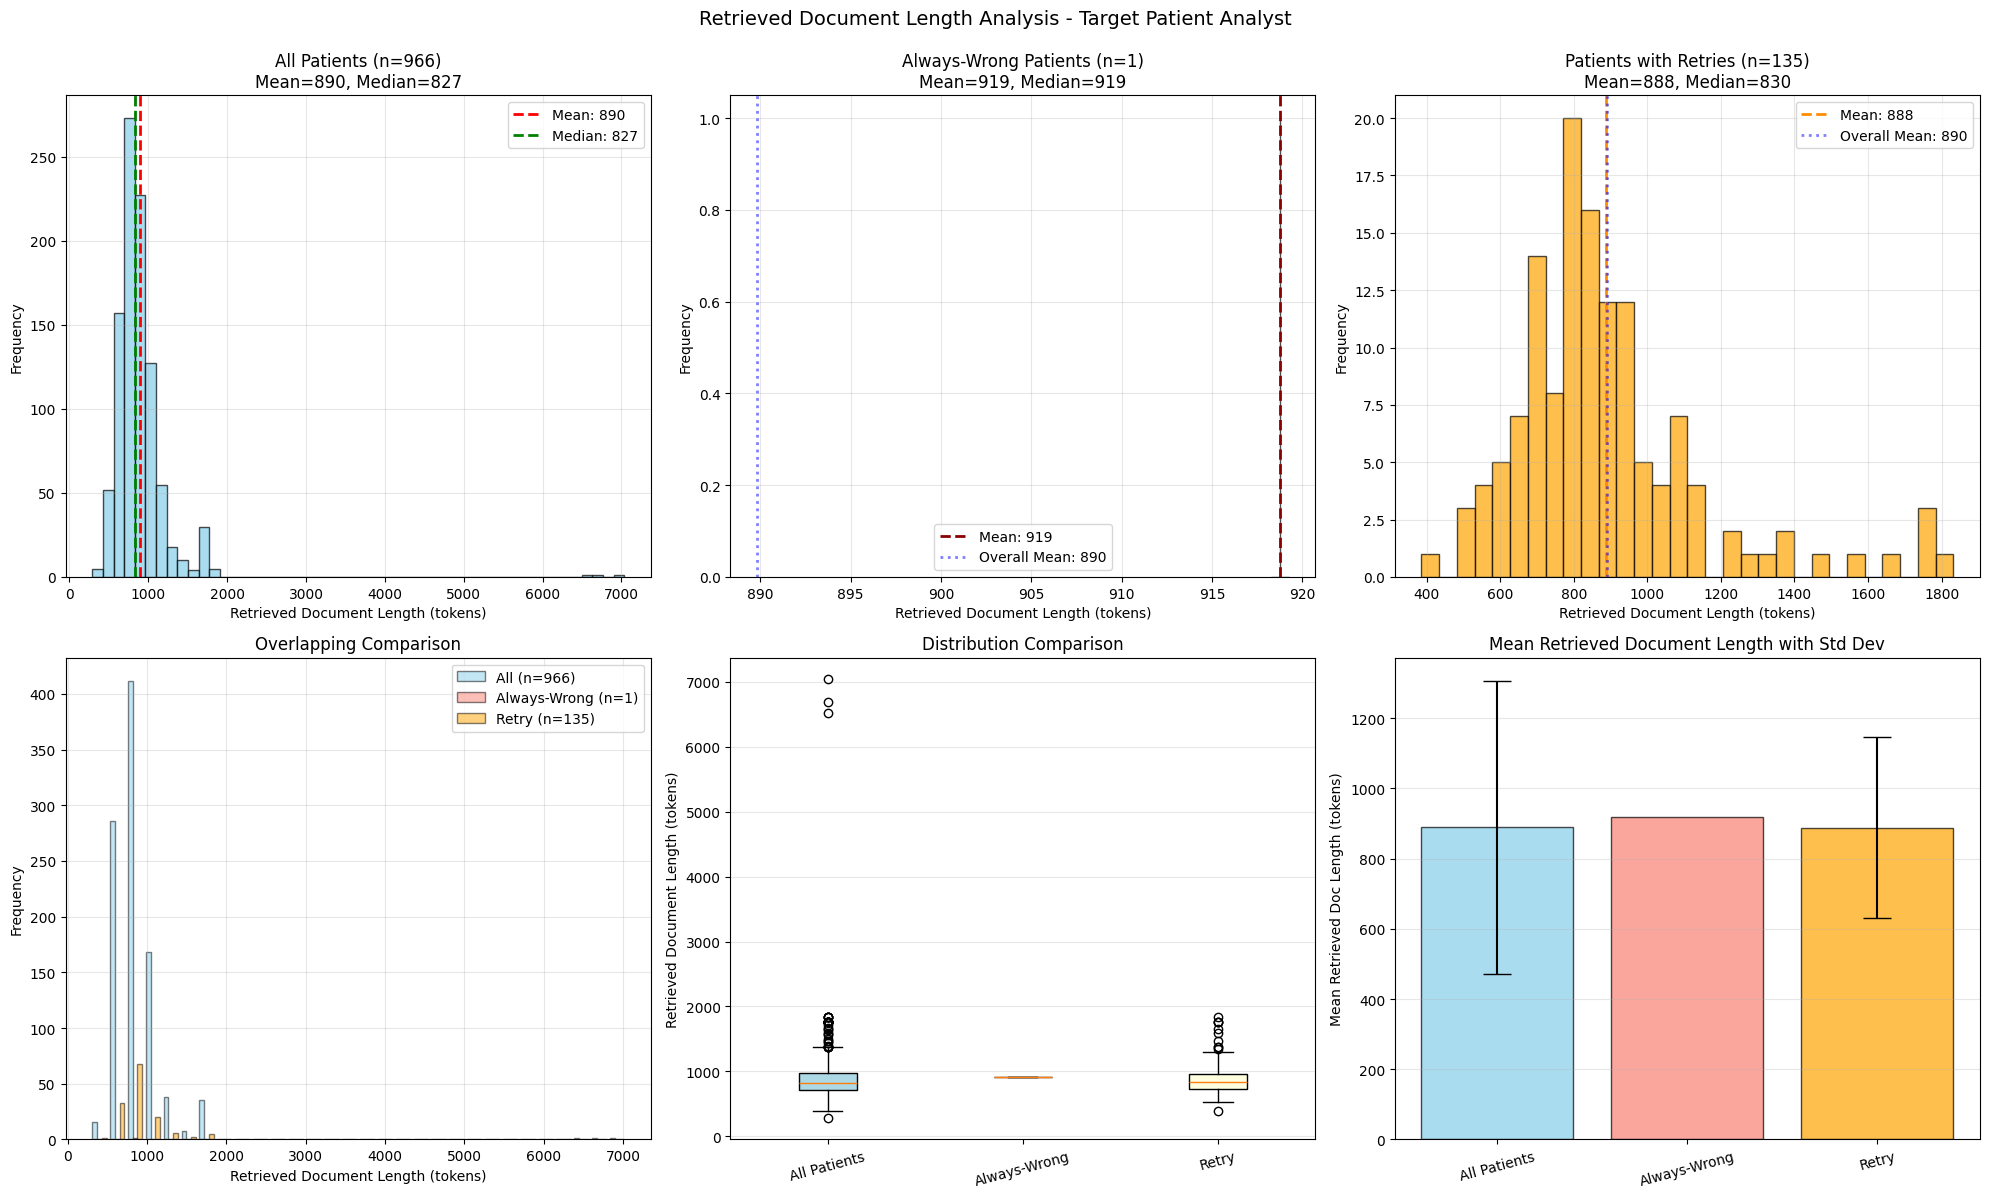


STATISTICS FOR TARGET PATIENT ANALYST

All Patients (n=966):
  Mean: 889.80 tokens
  Median: 826.75 tokens
  Std: 417.44 tokens
  Min: 289, Max: 7036

Always-Wrong Patients (n=1):
  Mean: 918.75 tokens
  Median: 918.75 tokens
  Std: nan tokens
  Min: 919, Max: 919
  Difference from overall mean: +28.95 tokens (+3.25%)

Patients with Retries (n=135):
  Mean: 887.57 tokens
  Median: 830.50 tokens
  Std: 257.89 tokens
  Min: 386, Max: 1832
  Difference from overall mean: -2.23 tokens (-0.25%)

Statistical Test: All vs Always-Wrong
  t-statistic: -0.0693
  p-value: 0.9448
  → No significant difference (p >= 0.05)

Statistical Test: All vs Retry
  t-statistic: 0.0605
  p-value: 0.9517
  → No significant difference (p >= 0.05)

Statistical Test: Always-Wrong vs Retry
  t-statistic: 0.1205
  p-value: 0.9043
  → No significant difference (p >= 0.05)

ROLE: Mortality Risk Assessor
Retrieved documents collected:
  All patients: 964
  Always-wrong patients: 1
  Retry patients: 135


/tmp/ipykernel_1871161/3748718748.py:183: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(box_data, labels=labels, patch_artist=True)


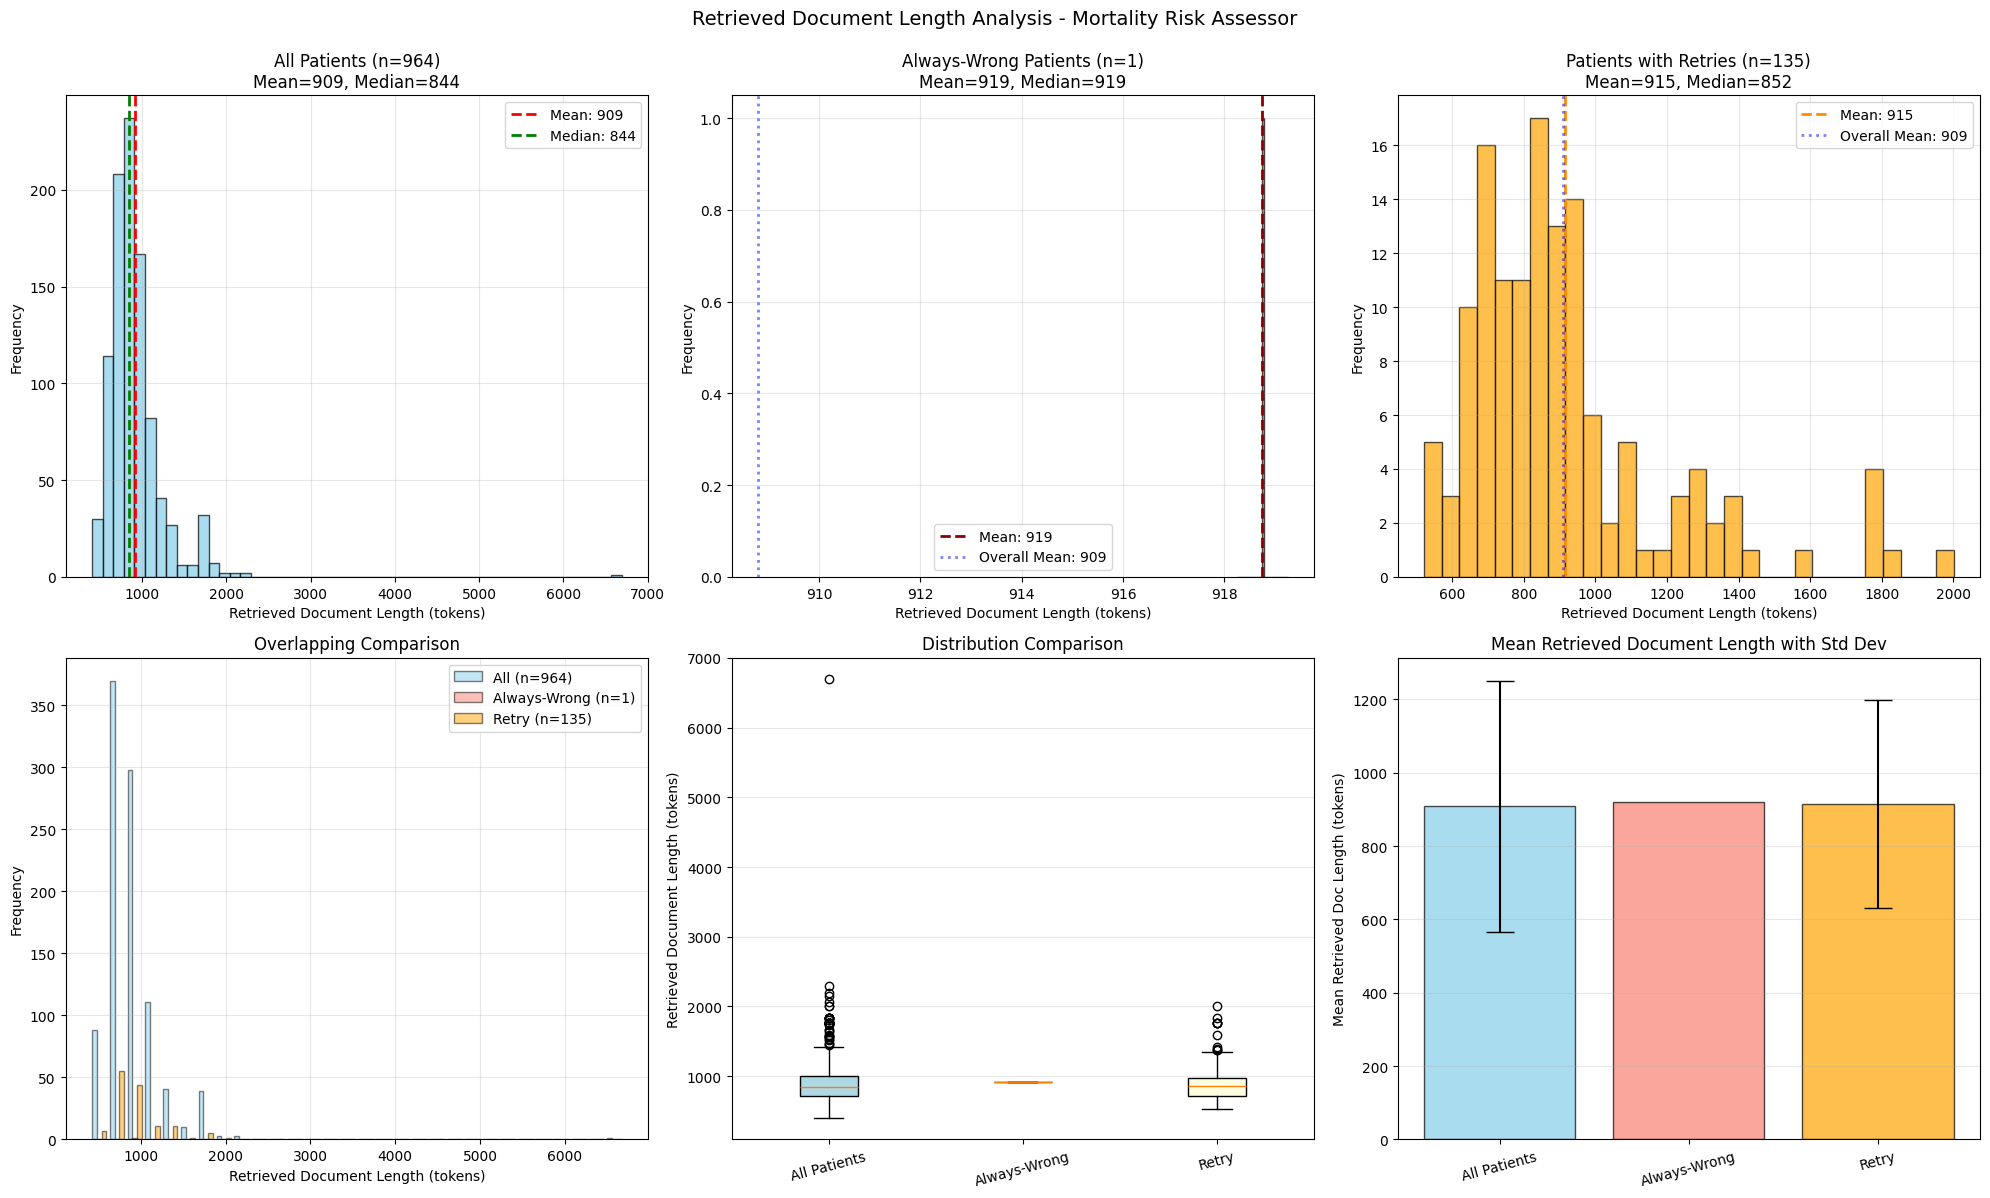


STATISTICS FOR MORTALITY RISK ASSESSOR

All Patients (n=964):
  Mean: 908.80 tokens
  Median: 844.12 tokens
  Std: 342.47 tokens
  Min: 406, Max: 6691

Always-Wrong Patients (n=1):
  Mean: 918.75 tokens
  Median: 918.75 tokens
  Std: nan tokens
  Min: 919, Max: 919
  Difference from overall mean: +9.95 tokens (+1.10%)

Patients with Retries (n=135):
  Mean: 915.22 tokens
  Median: 852.00 tokens
  Std: 283.70 tokens
  Min: 521, Max: 2000
  Difference from overall mean: +6.42 tokens (+0.71%)

Statistical Test: All vs Always-Wrong
  t-statistic: -0.0291
  p-value: 0.9768
  → No significant difference (p >= 0.05)

Statistical Test: All vs Retry
  t-statistic: -0.2082
  p-value: 0.8351
  → No significant difference (p >= 0.05)

Statistical Test: Always-Wrong vs Retry
  t-statistic: 0.0124
  p-value: 0.9901
  → No significant difference (p >= 0.05)

ROLE: Protective Factor Analyst
Retrieved documents collected:
  All patients: 964
  Always-wrong patients: 1
  Retry patients: 135


/tmp/ipykernel_1871161/3748718748.py:183: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(box_data, labels=labels, patch_artist=True)


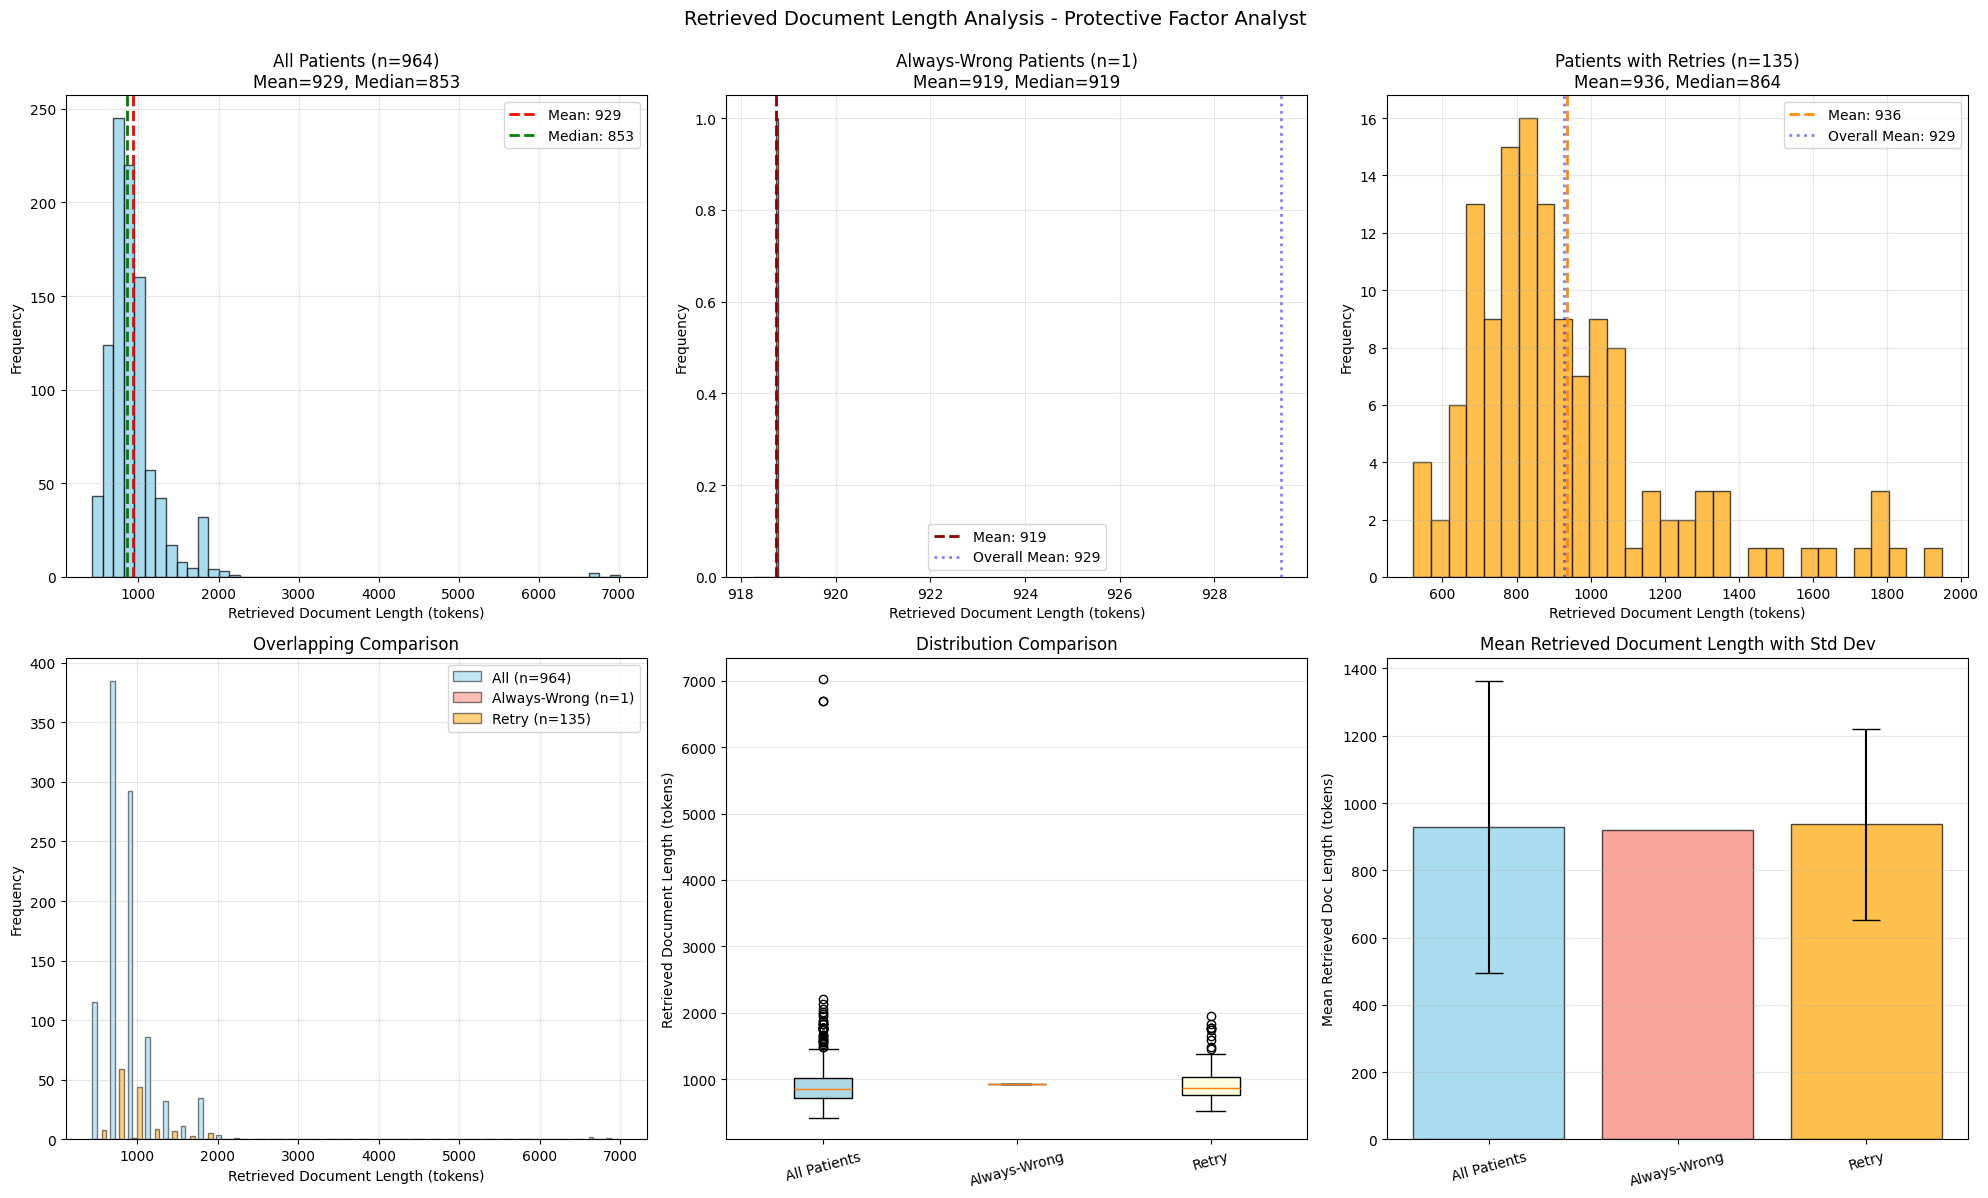


STATISTICS FOR PROTECTIVE FACTOR ANALYST

All Patients (n=964):
  Mean: 929.41 tokens
  Median: 853.12 tokens
  Std: 434.64 tokens
  Min: 420, Max: 7022

Always-Wrong Patients (n=1):
  Mean: 918.75 tokens
  Median: 918.75 tokens
  Std: nan tokens
  Min: 919, Max: 919
  Difference from overall mean: -10.66 tokens (-1.15%)

Patients with Retries (n=135):
  Mean: 936.39 tokens
  Median: 863.75 tokens
  Std: 284.77 tokens
  Min: 521, Max: 1948
  Difference from overall mean: +6.98 tokens (+0.75%)

Statistical Test: All vs Always-Wrong
  t-statistic: 0.0245
  p-value: 0.9804
  → No significant difference (p >= 0.05)

Statistical Test: All vs Retry
  t-statistic: -0.1811
  p-value: 0.8563
  → No significant difference (p >= 0.05)

Statistical Test: Always-Wrong vs Retry
  t-statistic: -0.0617
  p-value: 0.9509
  → No significant difference (p >= 0.05)

CROSS-ROLE COMPARISON SUMMARY
Model: rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_bri

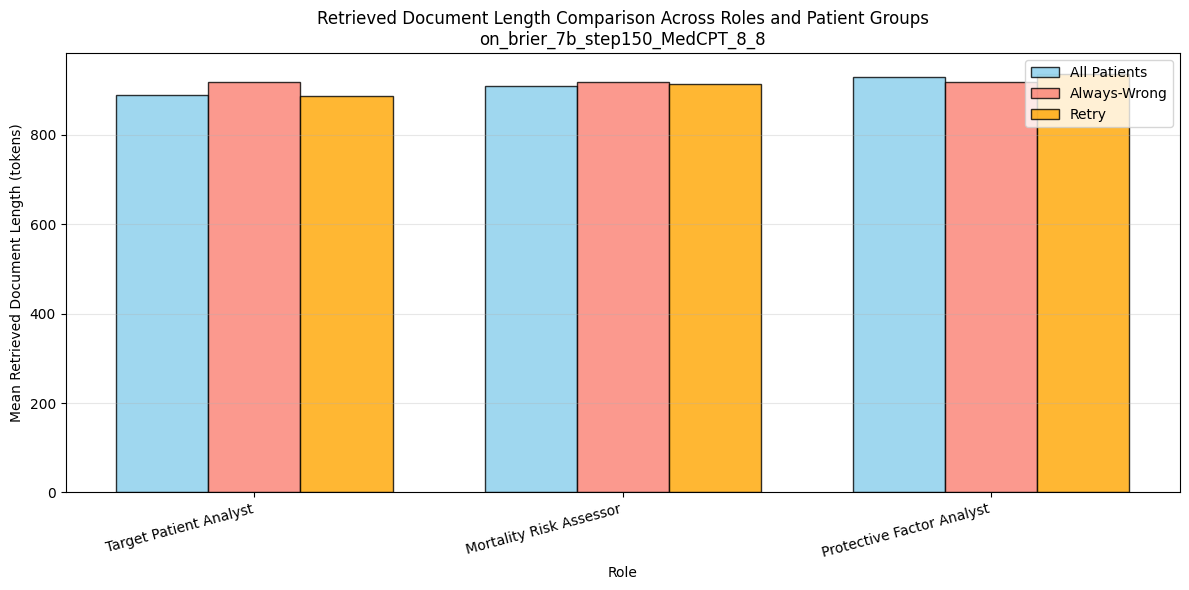

In [21]:
# Analyze retrieved document lengths for each role across patient groups
# Compare 3 groups: all patients, always-wrong patients, retry patients
# Roles: target_patient_analyst, mortality_risk_assessor, protective_factor_analyst

import re

def extract_retrieved_doc_length(retrieve_file_path):
    """Extract total retrieved document content length from a retrieve JSON file."""
    try:
        with open(retrieve_file_path, 'r', encoding='utf-8', errors='ignore') as f:
            data = json.load(f)
        
        # Calculate total content length from all retrieved documents
        total_length = 0
        if 'retrieved_documents' in data:
            for doc in data['retrieved_documents']:
                if 'content' in doc:
                    total_length += len(doc['content'])
        
        # Convert to tokens (approx 4 chars per token)
        return total_length / 4
    except Exception as e:
        return None

# Define roles to analyze
roles = ['target_patient_analyst', 'mortality_risk_assessor', 'protective_factor_analyst']

# Focus on specific model
target_model = 'rag_mor_Qwen_Qwen2.5_7B_Instruct_int__projects_slmreasoning_junh_Debate_KARE_verl_models_prediction_brier_7b_step150_MedCPT_8_8'

print(f"Analyzing retrieved document lengths for model: {target_model}")
print("=" * 80)

model_path = os.path.join(base_path_rag, target_model)
debate_logs_path = os.path.join(model_path, 'debate_logs')

if not os.path.isdir(debate_logs_path):
    print(f"ERROR: Model directory not found at {model_path}")
else:
    print(f"Found debate logs at: {debate_logs_path}\n")
    
    # Initialize storage for this model
    role_lengths = {role: [] for role in roles}
    
    # Get all retrieve JSON files
    retrieve_files = [f for f in os.listdir(debate_logs_path) if f.startswith('retrieve_') and f.endswith('.json')]
    
    print(f"Total retrieve files found: {len(retrieve_files)}")
    
    # Count files per role
    role_file_counts = {role: 0 for role in roles}
    
    for retrieve_file in retrieve_files:
        # Parse filename: retrieve_{role}_{patient_id}_{visit_id}.json
        match = re.match(r'retrieve_([^_]+(?:_[^_]+)*)_(\d+)_(\d+)\.json', retrieve_file)
        
        if match:
            role = match.group(1)
            patient_id = f"{match.group(2)}_{match.group(3)}"
            
            if role in roles:
                role_file_counts[role] += 1
                retrieve_path = os.path.join(debate_logs_path, retrieve_file)
                doc_length = extract_retrieved_doc_length(retrieve_path)
                
                if doc_length is not None:
                    role_lengths[role].append({
                        'patient_id': patient_id,
                        'doc_length': doc_length
                    })
    
    print(f"\nRetrieve files per role:")
    for role in roles:
        print(f"  {role}: {role_file_counts[role]} files, {len(role_lengths[role])} successfully parsed")
    
    # Store the role lengths directly (no loop over models anymore)
    aggregated_role_lengths = role_lengths

    # Convert to DataFrames for easier filtering
    role_dfs = {}
    for role, lengths_list in aggregated_role_lengths.items():
        if len(lengths_list) > 0:
            role_dfs[role] = pd.DataFrame(lengths_list)
    
    # Now analyze by patient groups
    print("\n" + "=" * 80)
    print("RETRIEVED DOCUMENT LENGTH ANALYSIS BY ROLE AND PATIENT GROUP")
    print(f"Model: {target_model}")
    print("=" * 80)
    
    # Get patient groups
    always_wrong_ids = always_wrong if 'always_wrong' in locals() else []
    retry_patient_ids = list(all_retry_patients.keys()) if 'all_retry_patients' in locals() else []
    
    print(f"\nPatient groups:")
    print(f"  Total patients analyzed: {len(patient_data)}")
    print(f"  Always-wrong patients: {len(always_wrong_ids)}")
    print(f"  Patients with retries: {len(retry_patient_ids)}")
    
    # Create comprehensive comparison plots for each role
    role_names_display = {
        'target_patient_analyst': 'Target Patient Analyst',
        'mortality_risk_assessor': 'Mortality Risk Assessor',
        'protective_factor_analyst': 'Protective Factor Analyst'
    }
    
    colors_groups = ['skyblue', 'salmon', 'orange']
    
    for role, role_df in role_dfs.items():
        print(f"\n{'=' * 80}")
        print(f"ROLE: {role_names_display[role]}")
        print('=' * 80)
        
        # Filter data for each group
        all_lengths = role_df['doc_length']
        always_wrong_lengths = role_df[role_df['patient_id'].isin(always_wrong_ids)]['doc_length']
        retry_lengths = role_df[role_df['patient_id'].isin(retry_patient_ids)]['doc_length']
        
        print(f"Retrieved documents collected:")
        print(f"  All patients: {len(all_lengths)}")
        print(f"  Always-wrong patients: {len(always_wrong_lengths)}")
        print(f"  Retry patients: {len(retry_lengths)}")
        
        # Create comparison plots
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        
        # Plot 1: Overall distribution
        axes[0, 0].hist(all_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 0].set_xlabel('Retrieved Document Length (tokens)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title(f'All Patients (n={len(all_lengths)})\nMean={all_lengths.mean():.0f}, Median={all_lengths.median():.0f}')
        axes[0, 0].axvline(all_lengths.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_lengths.mean():.0f}')
        axes[0, 0].axvline(all_lengths.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {all_lengths.median():.0f}')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Always-wrong distribution
        if len(always_wrong_lengths) > 0:
            axes[0, 1].hist(always_wrong_lengths, bins=30, alpha=0.7, color='salmon', edgecolor='black')
            axes[0, 1].set_xlabel('Retrieved Document Length (tokens)')
            axes[0, 1].set_ylabel('Frequency')
            axes[0, 1].set_title(f'Always-Wrong Patients (n={len(always_wrong_lengths)})\nMean={always_wrong_lengths.mean():.0f}, Median={always_wrong_lengths.median():.0f}')
            axes[0, 1].axvline(always_wrong_lengths.mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {always_wrong_lengths.mean():.0f}')
            axes[0, 1].axvline(all_lengths.mean(), color='blue', linestyle=':', linewidth=2, alpha=0.5, label=f'Overall Mean: {all_lengths.mean():.0f}')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
        else:
            axes[0, 1].text(0.5, 0.5, 'No always-wrong patients', ha='center', va='center', transform=axes[0, 1].transAxes)
            axes[0, 1].set_title('Always-Wrong Patients')
        
        # Plot 3: Retry distribution
        if len(retry_lengths) > 0:
            axes[0, 2].hist(retry_lengths, bins=30, alpha=0.7, color='orange', edgecolor='black')
            axes[0, 2].set_xlabel('Retrieved Document Length (tokens)')
            axes[0, 2].set_ylabel('Frequency')
            axes[0, 2].set_title(f'Patients with Retries (n={len(retry_lengths)})\nMean={retry_lengths.mean():.0f}, Median={retry_lengths.median():.0f}')
            axes[0, 2].axvline(retry_lengths.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'Mean: {retry_lengths.mean():.0f}')
            axes[0, 2].axvline(all_lengths.mean(), color='blue', linestyle=':', linewidth=2, alpha=0.5, label=f'Overall Mean: {all_lengths.mean():.0f}')
            axes[0, 2].legend()
            axes[0, 2].grid(True, alpha=0.3)
        else:
            axes[0, 2].text(0.5, 0.5, 'No retry patients', ha='center', va='center', transform=axes[0, 2].transAxes)
            axes[0, 2].set_title('Patients with Retries')
        
        # Plot 4: Overlapping histograms for comparison
        axes[1, 0].hist([all_lengths, always_wrong_lengths, retry_lengths], bins=30, alpha=0.5, 
                        color=['skyblue', 'salmon', 'orange'], 
                        label=[f'All (n={len(all_lengths)})', 
                               f'Always-Wrong (n={len(always_wrong_lengths)})', 
                               f'Retry (n={len(retry_lengths)})'], 
                        edgecolor='black')
        axes[1, 0].set_xlabel('Retrieved Document Length (tokens)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Overlapping Comparison')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 5: Box plot comparison
        box_data = [all_lengths, always_wrong_lengths, retry_lengths] if len(always_wrong_lengths) > 0 and len(retry_lengths) > 0 else []
        labels = ['All Patients', 'Always-Wrong', 'Retry']
        
        if len(box_data) > 0:
            bp = axes[1, 1].boxplot(box_data, labels=labels, patch_artist=True)
            bp['boxes'][0].set_facecolor('lightblue')
            if len(bp['boxes']) > 1:
                bp['boxes'][1].set_facecolor('lightcoral')
            if len(bp['boxes']) > 2:
                bp['boxes'][2].set_facecolor('lightyellow')
            axes[1, 1].set_ylabel('Retrieved Document Length (tokens)')
            axes[1, 1].set_title('Distribution Comparison')
            axes[1, 1].grid(True, alpha=0.3, axis='y')
            axes[1, 1].tick_params(axis='x', rotation=15)
        else:
            axes[1, 1].text(0.5, 0.5, 'Insufficient data', ha='center', va='center', transform=axes[1, 1].transAxes)
        
        # Plot 6: Statistical summary bars
        if len(always_wrong_lengths) > 0 and len(retry_lengths) > 0:
            means = [all_lengths.mean(), always_wrong_lengths.mean(), retry_lengths.mean()]
            stds = [all_lengths.std(), always_wrong_lengths.std(), retry_lengths.std()]
            
            x_pos = np.arange(len(labels))
            axes[1, 2].bar(x_pos, means, yerr=stds, alpha=0.7, color=['skyblue', 'salmon', 'orange'], 
                           edgecolor='black', capsize=10)
            axes[1, 2].set_ylabel('Mean Retrieved Doc Length (tokens)')
            axes[1, 2].set_title('Mean Retrieved Document Length with Std Dev')
            axes[1, 2].set_xticks(x_pos)
            axes[1, 2].set_xticklabels(labels, rotation=15)
            axes[1, 2].grid(True, alpha=0.3, axis='y')
        else:
            axes[1, 2].text(0.5, 0.5, 'Insufficient data', ha='center', va='center', transform=axes[1, 2].transAxes)
        
        plt.suptitle(f'Retrieved Document Length Analysis - {role_names_display[role]}', fontsize=14, y=0.995)
        plt.tight_layout()
        plt.show()
        
        # Print detailed statistics
        print(f"\nSTATISTICS FOR {role_names_display[role].upper()}")
        print(f"\nAll Patients (n={len(all_lengths)}):")
        print(f"  Mean: {all_lengths.mean():.2f} tokens")
        print(f"  Median: {all_lengths.median():.2f} tokens")
        print(f"  Std: {all_lengths.std():.2f} tokens")
        print(f"  Min: {all_lengths.min():.0f}, Max: {all_lengths.max():.0f}")
        
        if len(always_wrong_lengths) > 0:
            print(f"\nAlways-Wrong Patients (n={len(always_wrong_lengths)}):")
            print(f"  Mean: {always_wrong_lengths.mean():.2f} tokens")
            print(f"  Median: {always_wrong_lengths.median():.2f} tokens")
            print(f"  Std: {always_wrong_lengths.std():.2f} tokens")
            print(f"  Min: {always_wrong_lengths.min():.0f}, Max: {always_wrong_lengths.max():.0f}")
            print(f"  Difference from overall mean: {always_wrong_lengths.mean() - all_lengths.mean():+.2f} tokens ({(always_wrong_lengths.mean() - all_lengths.mean())/all_lengths.mean()*100:+.2f}%)")
        
        if len(retry_lengths) > 0:
            print(f"\nPatients with Retries (n={len(retry_lengths)}):")
            print(f"  Mean: {retry_lengths.mean():.2f} tokens")
            print(f"  Median: {retry_lengths.median():.2f} tokens")
            print(f"  Std: {retry_lengths.std():.2f} tokens")
            print(f"  Min: {retry_lengths.min():.0f}, Max: {retry_lengths.max():.0f}")
            print(f"  Difference from overall mean: {retry_lengths.mean() - all_lengths.mean():+.2f} tokens ({(retry_lengths.mean() - all_lengths.mean())/all_lengths.mean()*100:+.2f}%)")
        
        # Statistical tests
        from scipy import stats
        
        if len(always_wrong_lengths) > 0:
            print(f"\nStatistical Test: All vs Always-Wrong")
            t_stat, p_value = stats.ttest_ind(all_lengths, always_wrong_lengths)
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.4f}")
            if p_value < 0.05:
                print(f"  → Significant difference detected (p < 0.05)")
            else:
                print(f"  → No significant difference (p >= 0.05)")
        
        if len(retry_lengths) > 0:
            print(f"\nStatistical Test: All vs Retry")
            t_stat, p_value = stats.ttest_ind(all_lengths, retry_lengths)
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.4f}")
            if p_value < 0.05:
                print(f"  → Significant difference detected (p < 0.05)")
            else:
                print(f"  → No significant difference (p >= 0.05)")
        
        if len(always_wrong_lengths) > 0 and len(retry_lengths) > 0:
            print(f"\nStatistical Test: Always-Wrong vs Retry")
            t_stat, p_value = stats.ttest_ind(always_wrong_lengths, retry_lengths)
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.4f}")
            if p_value < 0.05:
                print(f"  → Significant difference detected (p < 0.05)")
            else:
                print(f"  → No significant difference (p >= 0.05)")
    
    # Summary comparison across roles
    print("\n" + "=" * 80)
    print("CROSS-ROLE COMPARISON SUMMARY")
    print(f"Model: {target_model}")
    print("=" * 80)
    
    summary_data = []
    for role, role_df in role_dfs.items():
        all_lengths = role_df['doc_length']
        always_wrong_lengths = role_df[role_df['patient_id'].isin(always_wrong_ids)]['doc_length']
        retry_lengths = role_df[role_df['patient_id'].isin(retry_patient_ids)]['doc_length']
        
        summary_data.append({
            'Role': role_names_display[role],
            'All_Mean': all_lengths.mean(),
            'All_Std': all_lengths.std(),
            'AlwaysWrong_Mean': always_wrong_lengths.mean() if len(always_wrong_lengths) > 0 else np.nan,
            'AlwaysWrong_Std': always_wrong_lengths.std() if len(always_wrong_lengths) > 0 else np.nan,
            'Retry_Mean': retry_lengths.mean() if len(retry_lengths) > 0 else np.nan,
            'Retry_Std': retry_lengths.std() if len(retry_lengths) > 0 else np.nan
        })
    
    summary_df = pd.DataFrame(summary_data)
    print("\nMean retrieved document lengths (tokens) by role and patient group:")
    print(summary_df.to_string(index=False))
    
    # Create a grouped bar chart comparing roles
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(role_names_display))
    width = 0.25
    
    all_means = [summary_df.loc[summary_df['Role'] == role_names_display[role], 'All_Mean'].values[0] for role in roles]
    aw_means = [summary_df.loc[summary_df['Role'] == role_names_display[role], 'AlwaysWrong_Mean'].values[0] for role in roles]
    retry_means = [summary_df.loc[summary_df['Role'] == role_names_display[role], 'Retry_Mean'].values[0] for role in roles]
    
    ax.bar(x - width, all_means, width, label='All Patients', alpha=0.8, color='skyblue', edgecolor='black')
    ax.bar(x, aw_means, width, label='Always-Wrong', alpha=0.8, color='salmon', edgecolor='black')
    ax.bar(x + width, retry_means, width, label='Retry', alpha=0.8, color='orange', edgecolor='black')
    
    ax.set_xlabel('Role')
    ax.set_ylabel('Mean Retrieved Document Length (tokens)')
    ax.set_title(f'Retrieved Document Length Comparison Across Roles and Patient Groups\n{target_model[-30:]}')
    ax.set_xticks(x)
    ax.set_xticklabels([role_names_display[role] for role in roles], rotation=15, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
plt.show()

- Patient context length is not what make the error patients be different with the dataset.